<a href="https://colab.research.google.com/github/deep-diver/keras-sd-serving/blob/main/notebooks/tfs_three_endpoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates how to pass inputs to each part of Stable Diffusion deployed within [TF Serving](https://www.tensorflow.org/tfx/guide/serving).

## Setup

In [ ]:
!pip install tensorflow
!pip install tensorflow_datasets
!pip install git+https://github.com/keras-team/keras-cv -q

## Prepare tokens

In [ ]:
import requests
import tensorflow as tf
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer

2022-12-27 16:15:13.417326: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-27 16:15:21.162590: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-12-27 16:15:21.163505: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.


In [ ]:
MAX_PROMPT_LENGTH = 77
PADDING_TOKEN = 49407

prompt = "photograph of an astronaut riding a horse in a green desert"
batch_size = 4
num_steps = 25

In [ ]:
tokenizer = SimpleTokenizer()
tokens = tokenizer.encode(prompt)
tokens = tokens + [PADDING_TOKEN] * (MAX_PROMPT_LENGTH - len(tokens))
tokens = tf.convert_to_tensor([tokens], dtype=tf.int32)
tokens

<tf.Tensor: shape=(1, 77), dtype=int32, numpy=
array([[49406,  8853,   539,   550, 18376,  6765,   320,  4558,   530,
          320,  1901,  7301, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407]], dtype=int32)>

## Token -> Text Encoder

In [ ]:
import json
import base64

data = json.dumps(
    {
        "signature_name": "serving_default", 
        "inputs": {
            "tokens": tokens.numpy().tolist(),
            "batch_size": batch_size
        }
})
print("Data: {} ... {}".format(data[:50], data[len(data) - 52 :]))

Data: {"signature_name": "serving_default", "inputs": {" ... 407, 49407, 49407, 49407, 49407]], "batch_size": 4}}


In [ ]:
ADDRESS = "35.223.196.169"

headers = {"content-type": "application/json"}

response = requests.post(
    f"http://{ADDRESS}:8501/v1/models/text-encoder:predict", data=data, headers=headers
)

In [ ]:
response

<Response [200]>

In [ ]:
json_response = json.loads(response.text)

## Text Encoder -> Diffusion Model

In [ ]:
import json
import base64

data = json.dumps(
    {
        "signature_name": "serving_default", 
        "inputs": {
            "batch_size": batch_size,
            "context": json_response['outputs']['context'],
            "num_steps": num_steps,
            "unconditional_context": json_response['outputs']['unconditional_context']
        }
})

print("Data: {} ... {}".format(data[:50], data[len(data) - 52 :]))

Data: {"signature_name": "serving_default", "inputs": {" ... 13616526, 1.61077094, -1.01735497, -0.248378605]]]}}


In [ ]:
ADDRESS = "127.0.0.1"

headers = {
    "content-type": "application/json"
}

response = requests.post(
    f"http://{ADDRESS}:8501/v1/models/diffusion-model:predict", data=data, headers=headers
)

In [ ]:
response

<Response [200]>

In [ ]:
json_response = json.loads(response.text)

## Diffusion Model -> Decoder

In [ ]:
import json
import base64

data = json.dumps(
    {
        "signature_name": "serving_default", 
        "inputs": {
            "latent": json_response['outputs'],
        }
})

print("Data: {} ... {}".format(data[:50], data[len(data) - 52 :]))

Data: {"signature_name": "serving_default", "inputs": {" ... 514778, 0.0969543606, 0.457462698, 0.747850716]]]]}}


In [ ]:
ADDRESS = "127.0.0.1"

headers = {
    "content-type": "application/json"
}

response = requests.post(
    f"http://{ADDRESS}:8501/v1/models/decoder:predict", data=data, headers=headers
)

In [ ]:
response

<Response [200]>

In [ ]:
json_response = json.loads(response.text)

In [ ]:
tf.convert_to_tensor(json_response['outputs'])

## Display the generated images

In [ ]:
import matplotlib.pyplot as plt


def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

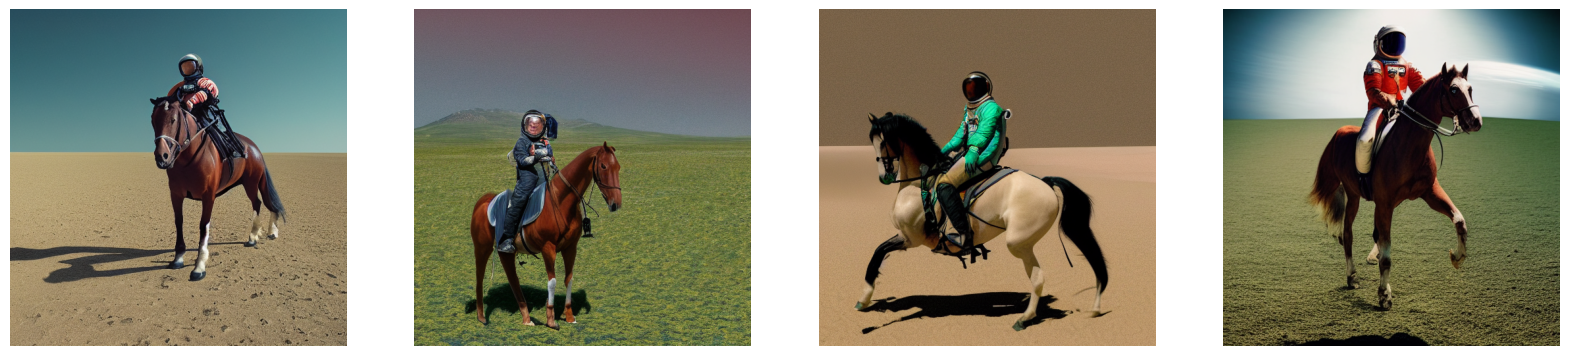

In [ ]:
plot_images(tf.convert_to_tensor(json_response['outputs']).numpy())